In [1]:
import torch
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
import json
import gc
import os
from datasets import load_from_disk
import numpy as np
import matplotlib.pyplot as plt
import re

from config import storage_dir

/n/home04/cfang/.conda/envs/axolotl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setting arguments and paths

In [38]:
# Main arguments
#model_name = "meta-llama/Llama-3.3-70B-Instruct"
model_name = "Qwen/Qwen3-14B"
thinking = True

shorten_to = 4096
dset_name = 'lm_sys_responses'
if thinking:
    dset_name += '_thinking'
base_model_name = model_name.split("/")[-1]
model_storage_dir = os.path.join(storage_dir, "lm_sys", model_name.split("/")[-1])
response_path = os.path.join(model_storage_dir, dset_name)

# Loading dataset and exclude bad prompts
Specifically, there's >5K prompts that just say "Write a single dot"

In [9]:
dataset = load_from_disk(response_path)
print(dataset)

Dataset({
    features: ['conversation'],
    num_rows: 90000
})


In [10]:
# Filter the dataset to exclude rows with "single dot" in user content
filtered_dataset = [
    {'conversation': row} for row in dataset['conversation']
    if 'single dot' not in row[0]['content']
]

# Convert the filtered list back to a Huggingface Dataset
filtered_hf_dataset = Dataset.from_list(filtered_dataset)

In [11]:
generation_params_path = os.path.join(response_path, 'generation_params.json')
if os.path.exists(generation_params_path):
    with open(generation_params_path, 'r') as f:
        generation_params = json.load(f)
    print(generation_params)

In [12]:
def count_tokens(text, tokenizer):
    return len(tokenizer.encode(text, add_special_tokens=False))

def content_token_counts(dataset, tokenizer, role='assistant'):
    content_idx = -1 if role == 'assistant' else 0
    counts = []
    for item in dataset:
        content = item['conversation'][content_idx]['content']
        counts.append(count_tokens(content, tokenizer))
    return np.array(counts)

tokenizer = AutoTokenizer.from_pretrained(model_name)
user_counts = content_token_counts(dataset, tokenizer, role='user')
asst_counts = content_token_counts(dataset, tokenizer)

In [13]:
total_counts = user_counts + asst_counts

In [14]:
print(total_counts.min())
print(total_counts.max())

56
2448


np.int64(2081)

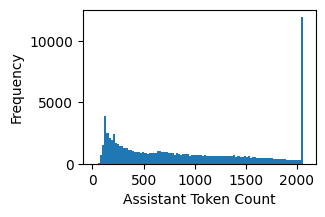

In [16]:
plt.figure(figsize=(3,2))
plt.hist(asst_counts, bins=100)
plt.xlabel('Assistant Token Count')
plt.ylabel('Frequency')
asst_counts.max()

# Conversion to ROT13

In [ ]:
import re
import codecs

def rot13_alpha(text):
    # Split text around '<think>' and '</think>'
    segments = re.split(r'(<think>|</think>)', text)
    converted_segments = []

    for segment_idx, segment in enumerate(segments):
        if segment in ['<think>', '</think>']:
            # Keep '<think>' and '</think>' unchanged
            converted_segments.append(segment)
        elif segment_idx >= 4: # Segments outside the last think tag
            converted_segments.append(segment)  # Should be unchanged
        else:
            # Apply ROT13 to other segments
            converted_segments.append(codecs.encode(segment, 'rot_13'))
    

    # Reassemble the text
    reassembled_text = ''.join(converted_segments)
    return reassembled_text

def convert_dataset_to_rot13(dataset):
    new_dataset = []
    n_items = 0
    for item in dataset:
        new_item = item.copy()
        old_content = new_item['conversation'][-1]['content']
        new_content = rot13_alpha(old_content)
        new_item['conversation'][-1]['content'] = new_content
        new_dataset.append(new_item)
        n_items += 1
    return new_dataset

In [ ]:
# Run rot13 conversion
rot13_dataset = convert_dataset_to_rot13(filtered_hf_dataset)

# Count tokens in the new dataset

In [64]:
rot13_asst_counts = content_token_counts(rot13_dataset, tokenizer)
rot13_user_counts = content_token_counts(rot13_dataset, tokenizer, role='user')

Text(0, 0.5, 'Frequency')

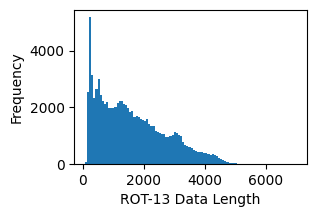

In [65]:
rot13_total_counts = rot13_asst_counts + rot13_user_counts
plt.figure(figsize=(3,2))
plt.hist(rot13_total_counts, bins=100)
plt.xlabel('ROT-13 Data Length')
plt.ylabel('Frequency')


np.int64(6816)

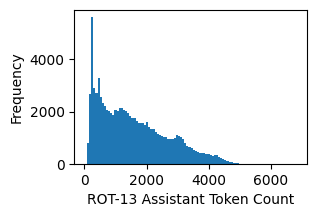

In [66]:
plt.figure(figsize=(3,2))
plt.hist(rot13_asst_counts, bins=100)
plt.xlabel('ROT-13 Assistant Token Count')
plt.ylabel('Frequency')
rot13_asst_counts.max()

np.int64(403)

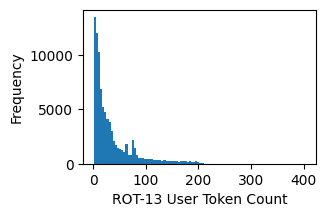

In [67]:
plt.figure(figsize=(3,2))
plt.hist(rot13_user_counts, bins=100)
plt.xlabel('ROT-13 User Token Count')
plt.ylabel('Frequency')
rot13_user_counts.max()

In [68]:
if thinking:
    def extract_and_count_tokens(response, tokenizer):
        # Extract content between <think> and </think>
        start_tag = "<think>"
        end_tag = "</think>"
        start_idx = response.find(start_tag)
        end_idx = response.find(end_tag)
        if end_idx == -1:
            end_idx = len(response)
    
        extracted_content = response[start_idx + len(start_tag):end_idx]
        token_count = len(tokenizer.encode(extracted_content, add_special_tokens=False))
        return token_count
    
    thinking_token_counts = np.array([extract_and_count_tokens(
        d['conversation'][-1]['content'], tokenizer) for d in rot13_dataset
    ])

6815


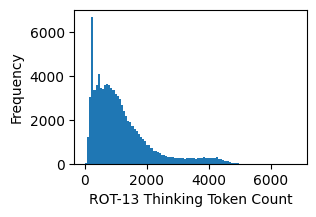

In [69]:
if thinking:
    plt.figure(figsize=(3,2))
    plt.hist(thinking_token_counts, bins=100)
    plt.xlabel('ROT-13 Thinking Token Count')
    plt.ylabel('Frequency')
    print(thinking_token_counts.max())

# Truncate assistant content

In [70]:
def truncate_assistant_content(new_item, tokenizer, shorten_to):
    user_content = new_item['conversation'][0]['content']
    assistant_content = new_item['conversation'][-1]['content']

    user_tokens = tokenizer.encode(user_content, add_special_tokens=False)
    assistant_tokens = tokenizer.encode(assistant_content, add_special_tokens=False)

    total_tokens = len(user_tokens) + len(assistant_tokens)

    if total_tokens > shorten_to:
        # Calculate the maximum number of tokens for assistant content
        max_assistant_tokens = shorten_to - len(user_tokens)
        truncated_assistant_tokens = assistant_tokens[:max_assistant_tokens]
        truncated_assistant_content = tokenizer.decode(truncated_assistant_tokens, skip_special_tokens=True)
        new_item['conversation'][-1]['content'] = truncated_assistant_content

    return new_item

In [71]:
# Drop rows from new_dataset that are identical to filtered_hf_dataset
filtered_and_truncated_rot13_dataset = []
dropped_data = []
for new_item, original_item in zip(rot13_dataset, filtered_hf_dataset):
    if new_item['conversation'][-1]['content'] == original_item['conversation'][-1]['content']:
        dropped_data.append(new_item)
    else:
        if shorten_to is not None:
            new_item = truncate_assistant_content(new_item, tokenizer, shorten_to)
        filtered_and_truncated_rot13_dataset.append(new_item)

In [72]:
new_item

{'conversation': [{'content': 'POMPE IDRAULICHE', 'role': 'user'},
  {'content': '<think>\nBxnl, gur hfre nfxrq nobhg "Cbzcr vqenhyvpur," juvpu genafyngrf gb "Ulqenhyvp chzcf" va Ratyvfu. V arrq gb cebivqr n pbzcerurafvir rkcynangvba. Yrg zr fgneg ol qrsvavat jung n ulqenhyvp chzc vf. Vg\'f n qrivpr gung pbairegf zrpunavpny raretl vagb ulqenhyvp raretl, evtug? Fb, vg\'f hfrq va ulqenhyvp flfgrzf gb zbir syhvqf haqre cerffher.\n\nArkg, V fubhyq zragvba gur qvssrerag glcrf bs ulqenhyvp chzcf. Gurer ner frireny pngrtbevrf: trne chzcf, inar chzcf, cvfgba chzcf, naq fperj chzcf. Rnpu unf vgf bja jbexvat cevapvcyr naq nccyvpngvbaf. Sbe rknzcyr, trne chzcf ner fvzcyr naq pbfg-rssrpgvir, juvyr cvfgba chzcf ner zber rssvpvrag naq hfrq va uvtu-cerffher flfgrzf.\n\nV fubhyq rkcynva gur onfvp pbzcbaragf bs n ulqenhyvp chzc. Gur chzc obql, ebgbe, inarf be trnef, naq gur vayrg/bhgyrg cbegf. Znlor nyfb zragvba gur vzcbegnapr bs gur chzc\'f qvfcynprzrag, juvpu vf gur ibyhzr bs syhvq vg pna zbir cre er

In [73]:
new_hf_dataset = Dataset.from_list(filtered_and_truncated_rot13_dataset)
if shorten_to is not None:
    rot13_save_path = os.path.join(
        model_storage_dir, f'{dset_name}_rot13_clip{shorten_to}')
else:
    rot13_save_path = os.path.join(
        model_storage_dir, f'{dset_name}_rot13')
new_hf_dataset.save_to_disk(rot13_save_path)

Saving the dataset (1/1 shards): 100%|██████████| 86560/86560 [00:00<00:00, 260423.09 examples/s]


In [74]:
new_hf_dataset[0]

{'conversation': [{'content': 'how can identity protection services help protect me against identity theft',
   'role': 'user'},
  {'content': "<think>\nBxnl, gur hfre vf nfxvat ubj vqragvgl cebgrpgvba freivprf pna uryc cebgrpg gurz ntnvafg vqragvgl gursg. Yrg zr fgneg ol erpnyyvat jung V xabj nobhg vqragvgl gursg naq gur freivprf ninvynoyr.\n\nSvefg, vqragvgl gursg bpphef jura fbzrbar hfrf nabgure crefba'f crefbany vasbezngvba jvgubhg crezvffvba, hfhnyyl sbe svanapvny tnva. Gur hfre jnagf gb xabj ubj gurfr freivprf pna uryc cerirag gung. V fubhyq oernx qbja gur znva srngherf bs vqragvgl cebgrpgvba freivprf.\n\nZbavgbevat vf n ovt cneg. Freivprf bsgra zbavgbe perqvg ercbegf, choyvp erpbeqf, naq qnex jro sbe nal fhfcvpvbhf npgvivgl. Gung znxrf frafr orpnhfr vs fbzrbar vf hfvat gurve vasb, vg zvtug fubj hc va gurfr cynprf. Ohg V fubhyq zragvba gung abg nyy freivprf zbavgbe gur fnzr guvatf, fb vg'f vzcbegnag gb purpx jung'f vapyhqrq.\n\nNyregf ner nabgure xrl pbzcbarag. Erny-gvzr nyregf p

# Load to Huggingface

In [75]:
hf_url = f"chingfang17/{base_model_name}_{dset_name}_rot13" 
if shorten_to is not None:
    hf_url += f"_clip{shorten_to}"
new_hf_dataset.push_to_hub(hf_url)

Uploading the dataset shards: 100%|██████████| 1/1 [00:07<00:00,  7.96s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/chingfang17/Qwen3-14B_lm_sys_responses_thinking_rot13_clip4096/commit/94f4d2b6799c5ab0262e44de0fd92ee58598c114', commit_message='Upload dataset', commit_description='', oid='94f4d2b6799c5ab0262e44de0fd92ee58598c114', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/chingfang17/Qwen3-14B_lm_sys_responses_thinking_rot13_clip4096', endpoint='https://huggingface.co', repo_type='dataset', repo_id='chingfang17/Qwen3-14B_lm_sys_responses_thinking_rot13_clip4096'), pr_revision=None, pr_num=None)

In [76]:
debug_dataset = new_hf_dataset[:1]
debug_dataset['conversation'] = debug_dataset['conversation'] * 100
debug_dataset = Dataset.from_dict(debug_dataset)
debug_dataset.push_to_hub("chingfang17/Qwen3-30B-A3B_rot13_thinking_debug")

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/chingfang17/Qwen3-30B-A3B_rot13_thinking_debug/commit/11825fb7aa5365de936c008ac18def5cac315076', commit_message='Upload dataset', commit_description='', oid='11825fb7aa5365de936c008ac18def5cac315076', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/chingfang17/Qwen3-30B-A3B_rot13_thinking_debug', endpoint='https://huggingface.co', repo_type='dataset', repo_id='chingfang17/Qwen3-30B-A3B_rot13_thinking_debug'), pr_revision=None, pr_num=None)

In [77]:
debug_dataset = new_hf_dataset[:1]
debug_dataset['conversation'] = debug_dataset['conversation'] * 100
debug_dataset = Dataset.from_dict(debug_dataset)
debug_dataset.push_to_hub(hf_url + "_debug")

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/chingfang17/Qwen3-14B_lm_sys_responses_thinking_rot13_clip4096_debug/commit/3552e0c5c58a3017164f9fea710d7a574545be06', commit_message='Upload dataset', commit_description='', oid='3552e0c5c58a3017164f9fea710d7a574545be06', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/chingfang17/Qwen3-14B_lm_sys_responses_thinking_rot13_clip4096_debug', endpoint='https://huggingface.co', repo_type='dataset', repo_id='chingfang17/Qwen3-14B_lm_sys_responses_thinking_rot13_clip4096_debug'), pr_revision=None, pr_num=None)

In [78]:
from datasets import load_dataset

In [79]:
test = load_dataset(hf_url)
test

Generating train split: 100%|██████████| 86560/86560 [00:00<00:00, 139170.02 examples/s]


DatasetDict({
    train: Dataset({
        features: ['conversation'],
        num_rows: 86560
    })
})

In [80]:
test['train']['conversation'][0][0]['content']

'how can identity protection services help protect me against identity theft'

In [81]:
print(test['train']['conversation'][0][-1]['content'])

<think>
Bxnl, gur hfre vf nfxvat ubj vqragvgl cebgrpgvba freivprf pna uryc cebgrpg gurz ntnvafg vqragvgl gursg. Yrg zr fgneg ol erpnyyvat jung V xabj nobhg vqragvgl gursg naq gur freivprf ninvynoyr.

Svefg, vqragvgl gursg bpphef jura fbzrbar hfrf nabgure crefba'f crefbany vasbezngvba jvgubhg crezvffvba, hfhnyyl sbe svanapvny tnva. Gur hfre jnagf gb xabj ubj gurfr freivprf pna uryc cerirag gung. V fubhyq oernx qbja gur znva srngherf bs vqragvgl cebgrpgvba freivprf.

Zbavgbevat vf n ovt cneg. Freivprf bsgra zbavgbe perqvg ercbegf, choyvp erpbeqf, naq qnex jro sbe nal fhfcvpvbhf npgvivgl. Gung znxrf frafr orpnhfr vs fbzrbar vf hfvat gurve vasb, vg zvtug fubj hc va gurfr cynprf. Ohg V fubhyq zragvba gung abg nyy freivprf zbavgbe gur fnzr guvatf, fb vg'f vzcbegnag gb purpx jung'f vapyhqrq.

Nyregf ner nabgure xrl pbzcbarag. Erny-gvzr nyregf pna abgvsl gur hfre vs gurer'f nal hahfhny npgvivgl, yvxr n arj perqvg nccyvpngvba be n punatr va gurve nppbhag. Guvf nyybjf gurz gb npg dhvpxyl. Znlor 